# Unphased Data Results

Summary stats for Linear Regression (Unphased):
        R2 Score  IQS Score  Accuracy Score  AUC Score
count  22.000000  22.000000       22.000000  22.000000
mean    0.821551   0.827436        0.893280   0.857419
std     0.058275   0.046574        0.033250   0.057703
min     0.726431   0.731621        0.819095   0.687836
25%     0.778571   0.802500        0.877003   0.845340
50%     0.827912   0.823748        0.885236   0.865303
75%     0.869323   0.850117        0.914970   0.890535
max     0.905384   0.909234        0.953870   0.949132
Summary stats for Logistic Regression (Phased):
        R2 Score  IQS Score   Accuracy    AUC ROC
count  22.000000  22.000000  22.000000  22.000000
mean    0.825000   0.884326   0.951146   0.985096
std     0.058051   0.040605   0.017963   0.007352
min     0.717266   0.806573   0.910978   0.969594
25%     0.772632   0.849980   0.939407   0.980259
50%     0.836042   0.888036   0.950399   0.987171
75%     0.858240   0.911873   0.962439   0.990725
max     0

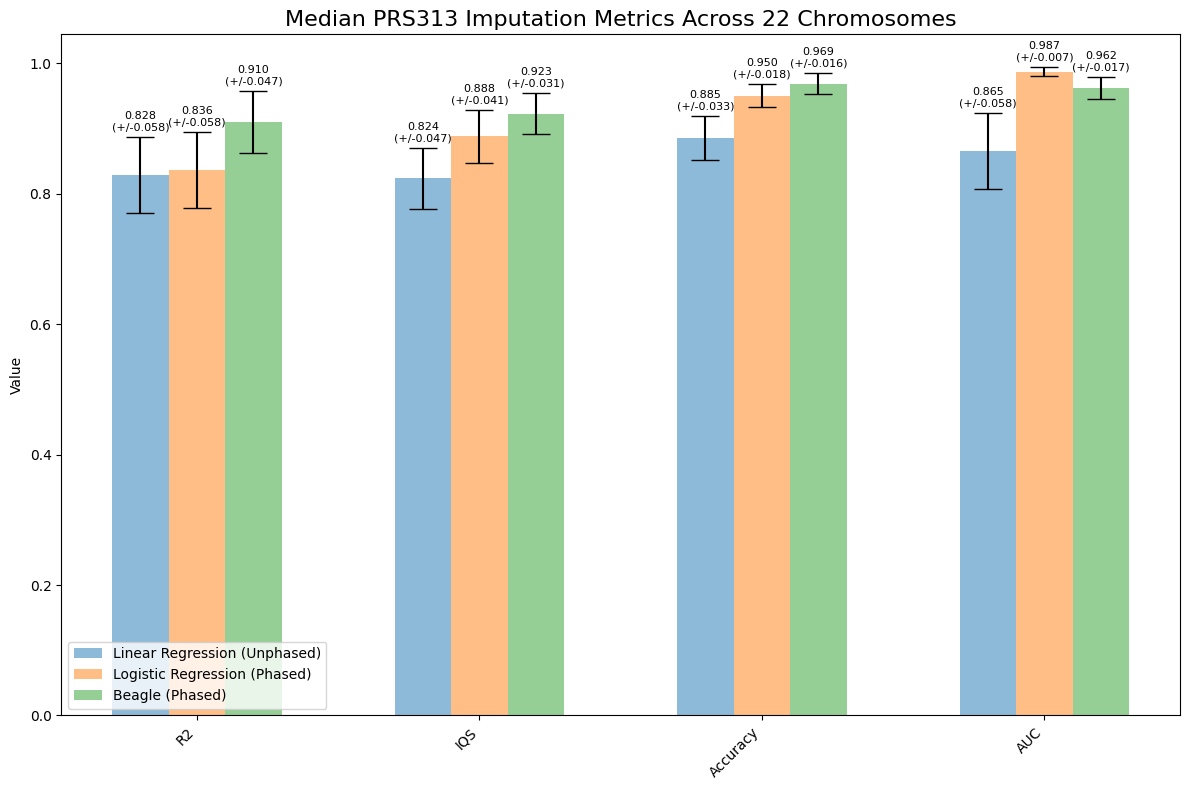

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

def read_csv_files(folder_path):
    return [pd.read_csv(os.path.join(folder_path, file_name)) 
            for file_name in os.listdir(folder_path) if file_name.endswith(".csv")]

def combine_dataframes(dataframes):
    return pd.concat(dataframes, ignore_index=True).dropna().drop(columns='Chromosome')

def calculate_summary_stats(df):
    return df.describe()

def extract_metrics(summary_stats):
    return summary_stats.loc['50%'].values, summary_stats.loc['std'].values

def plot_metrics(metrics, model_medians, model_std_devs, model_names):
    fig, ax = plt.subplots(figsize=(12, 8))
    x = range(len(metrics))
    width = 0.2  # the width of the bars

    for i, (medians, std_devs) in enumerate(zip(model_medians, model_std_devs)):
        bar_positions = [p + i * width for p in x]
        ax.bar(bar_positions, medians, width=width, yerr=std_devs, align='center', alpha=0.5, ecolor='black', capsize=10, label=model_names[i])
        
        for j, (median, std_dev) in enumerate(zip(medians, std_devs)):
            # Stagger the label positions to avoid overlap
            offset = (i % 2) * 0.0  # stagger by 0.1
            ax.text(bar_positions[j], median + std_dev + 0.01 + offset, f"{median:.3f}\n(+/-{std_dev:.3f})", ha='center', fontsize=8)

    ax.set_xticks([p + width * (len(model_names) - 1) / 2 for p in x])
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylabel('Value')
    ax.set_title('Median PRS313 Imputation Metrics Across 22 Chromosomes', fontsize=16)
    ax.legend()

    fig.tight_layout()
    plt.show()

def visualize_performance(model_paths):
    metrics = ['R2', "IQS", "Accuracy", "AUC"]
    
    model_medians = []
    model_std_devs = []
    model_names = []
    
    for model_name, folder_path in model_paths.items():
        dataframes = read_csv_files(folder_path)
        combined_df = combine_dataframes(dataframes)
        summary_stats = calculate_summary_stats(combined_df)
        medians, std_devs = extract_metrics(summary_stats)
        
        print(f"Summary stats for {model_name}:")
        print(summary_stats)
        
        model_medians.append(medians)
        model_std_devs.append(std_devs)
        model_names.append(model_name)
    
    plot_metrics(metrics, model_medians, model_std_devs, model_names)

# Example usage:
model_paths = {
    "Linear Regression (Unphased)": "../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files",
    "Logistic Regression (Phased)": "../../../Data/model_results/logistic_regression/csv_files",

    "Beagle (Phased)": "../../../Data/model_results_unphased_all_PRS/beagle/csv_files"
}

visualize_performance(model_paths)


/var/folders/dg/wr1k4k0942q6gr0vqnc6c5bm0000gn/T/ipykernel_30024/3321121966.py:53: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='chromosome', y='R2 Score', hue='model', data=main_data, split=True, inner='quart', palette=palette, bw=0.2)


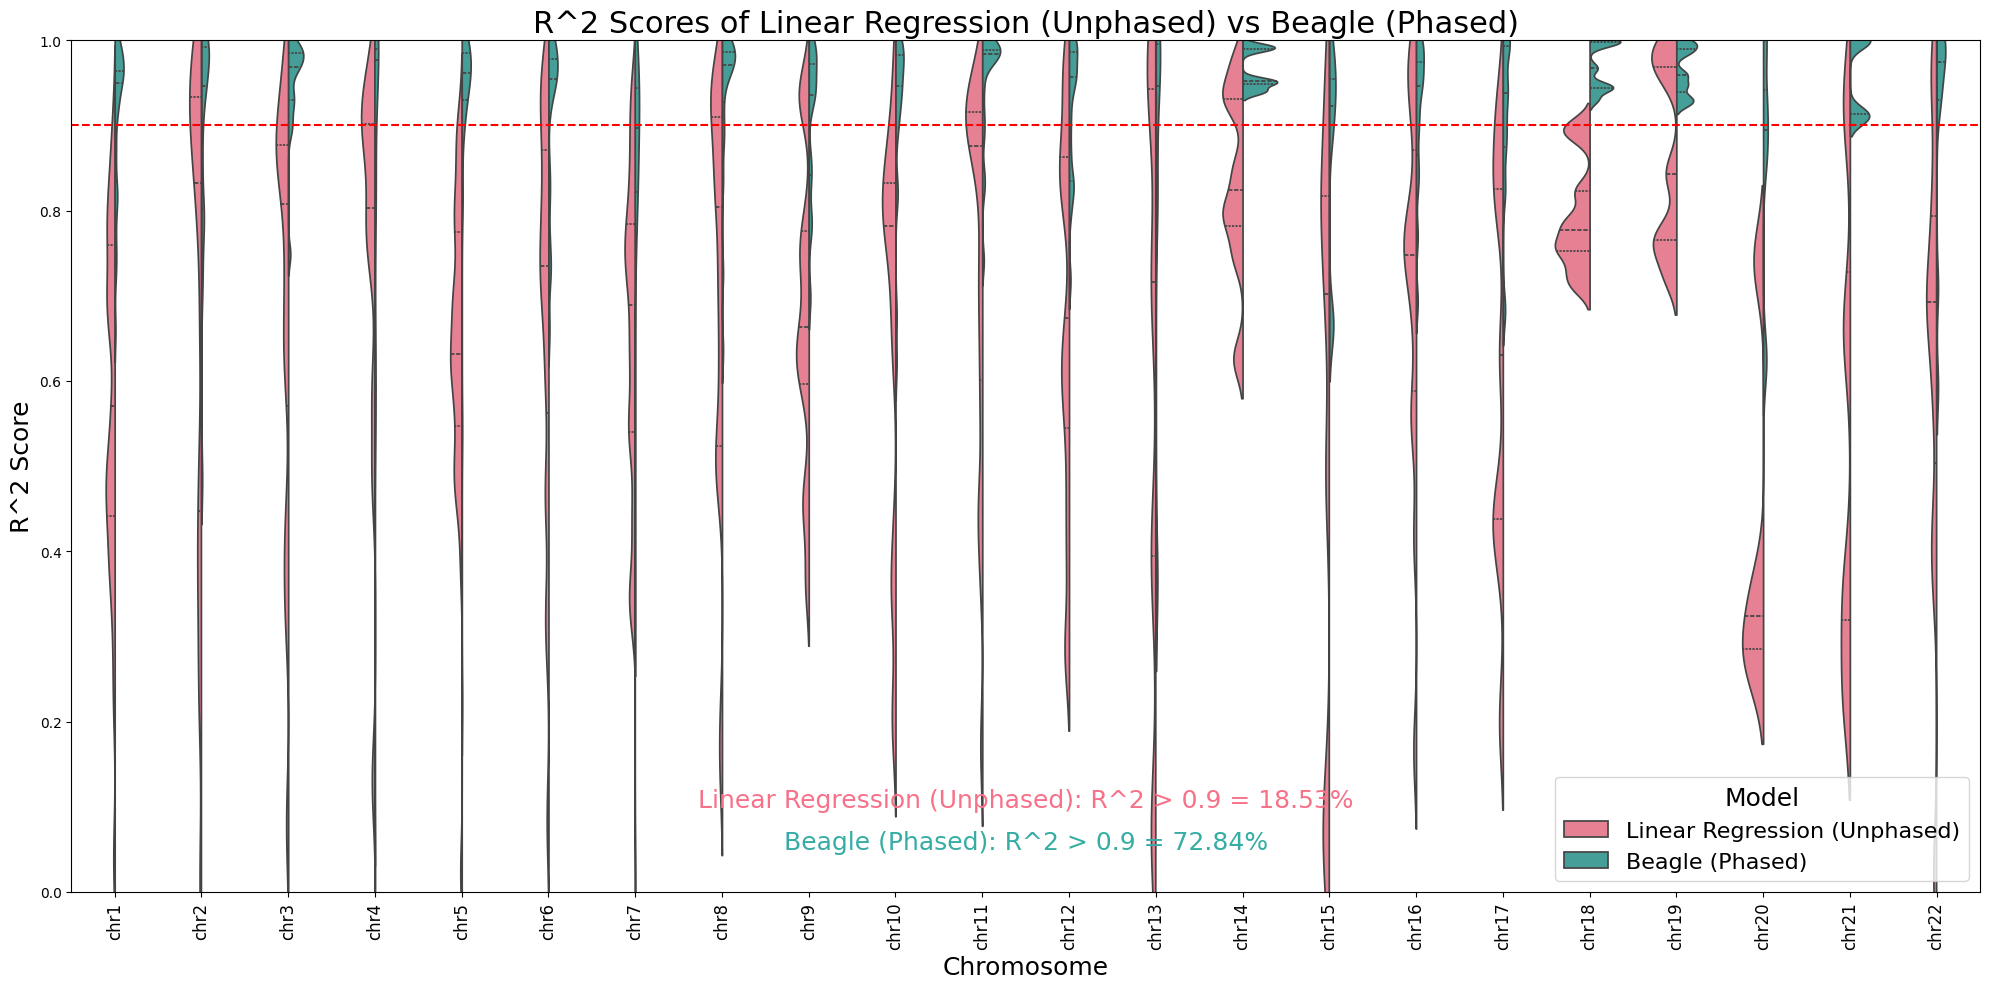

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to read and process CSV file
def read_and_process_csv(base_dir, chr_folder):
    csv_file = os.path.join(base_dir, chr_folder, f'individual_r2_scores_{chr_folder}.csv')
    df = pd.read_csv(csv_file)
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    df['position'] = pd.to_numeric(df['position'])
    df['chromosome'] = chr_folder  # Add chromosome as a column for easier plotting
    return df

# Define a function to create the violin plot data for a single model
def create_violin_plot_data(base_dir, model_label):
    chr_folders = sorted(
        (folder for folder in os.listdir(base_dir) if folder.startswith('chr')),
        key=lambda x: int(x[3:])
    )
    
    data_frames = []
    for chr_folder in chr_folders:
        df = read_and_process_csv(base_dir, chr_folder)
        df['model'] = model_label  # Add model label as a column
        data_frames.append(df)
    
    return pd.concat(data_frames, ignore_index=True)

# Define a function to plot the comparison with violin plots for multiple models
def plot_comparison_violin(models):
    combined_df = pd.concat(
        [create_violin_plot_data(base_dir, model_name) for base_dir, model_name in models], 
        ignore_index=True
    )

    # Check if any R² scores are greater than 1
    invalid_scores = combined_df[combined_df['R2 Score'] > 1]
    if not invalid_scores.empty:
        print("Invalid R² scores found:")
        print(invalid_scores)
    
    # Filter out invalid R² scores
    combined_df = combined_df[(combined_df['R2 Score'] >= 0) & (combined_df['R2 Score'] <= 1)]

    # Separate outliers from main data
    main_data = combined_df[(combined_df['R2 Score'] >= -1) & (combined_df['R2 Score'] <= 1)]
    outliers = combined_df[(combined_df['R2 Score'] < -1) | (combined_df['R2 Score'] > 1)]

       # Create the violin plot with adjusted y-axis limits and bandwidth
    plt.figure(figsize=(20, 10))
    palette = sns.color_palette("husl", len(models))
    sns.violinplot(x='chromosome', y='R2 Score', hue='model', data=main_data, split=True, inner='quart', palette=palette, bw=0.2)
    plt.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)
    plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
    plt.title(f'R^2 Scores of {models[0][1]} vs {models[1][1]}', fontsize=22)
    plt.xlabel('Chromosome', fontsize=18)
    plt.ylabel('R^2 Score', fontsize=18)
    plt.xticks(rotation=90, fontsize=12)
    plt.legend(title='Model', fontsize=16, title_fontsize=18, fancybox=True)

    # Plot outliers separately with model-specific colors
    model_color_map = {model_name: color for (base_dir, model_name), color in zip(models, palette)}
    
    for _, outlier in outliers.iterrows():
        y_position = -1.25 if outlier['R2 Score'] < -1 else 1.25
        model_color = model_color_map[outlier['model']]
        plt.scatter(outlier['chromosome'], y_position, color=model_color, edgecolor=model_color, s=100, linewidth=2, facecolor='none')
        
        # Adjust label position
        offset = 0.075 if y_position == 1.25 else -0.075
        plt.text(outlier['chromosome'], y_position + offset, f"{outlier['R2 Score']:.2f}", color='black', fontsize=12, ha='center', va='center')

    # Calculate and display the proportion of data points with R² > 0.9 for each model
    for i, (base_dir, model_name) in enumerate(models):
        model_data = combined_df[combined_df['model'] == model_name]
        proportion_above_0_9 = (model_data['R2 Score'] > 0.9).mean()
        plt.text(0.5, 0.1 - 0.05 * i, f'{model_name}: R^2 > 0.9 = {proportion_above_0_9:.2%}', transform=plt.gca().transAxes, fontsize=18, color=palette[i], ha='center')

    plt.tight_layout()
    plt.show()

# Define the base directory paths and model names
models = [
    ("../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files", "Linear Regression (Unphased)"),
    ("../../../Data/model_results_unphased_all_PRS/beagle/csv_files", "Beagle (Phased)")
    # Add more tuples for additional models as needed
]

# Create the comparison plot with violin plots
plot_comparison_violin(models)


/var/folders/dg/wr1k4k0942q6gr0vqnc6c5bm0000gn/T/ipykernel_30024/3321121966.py:53: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='chromosome', y='R2 Score', hue='model', data=main_data, split=True, inner='quart', palette=palette, bw=0.2)


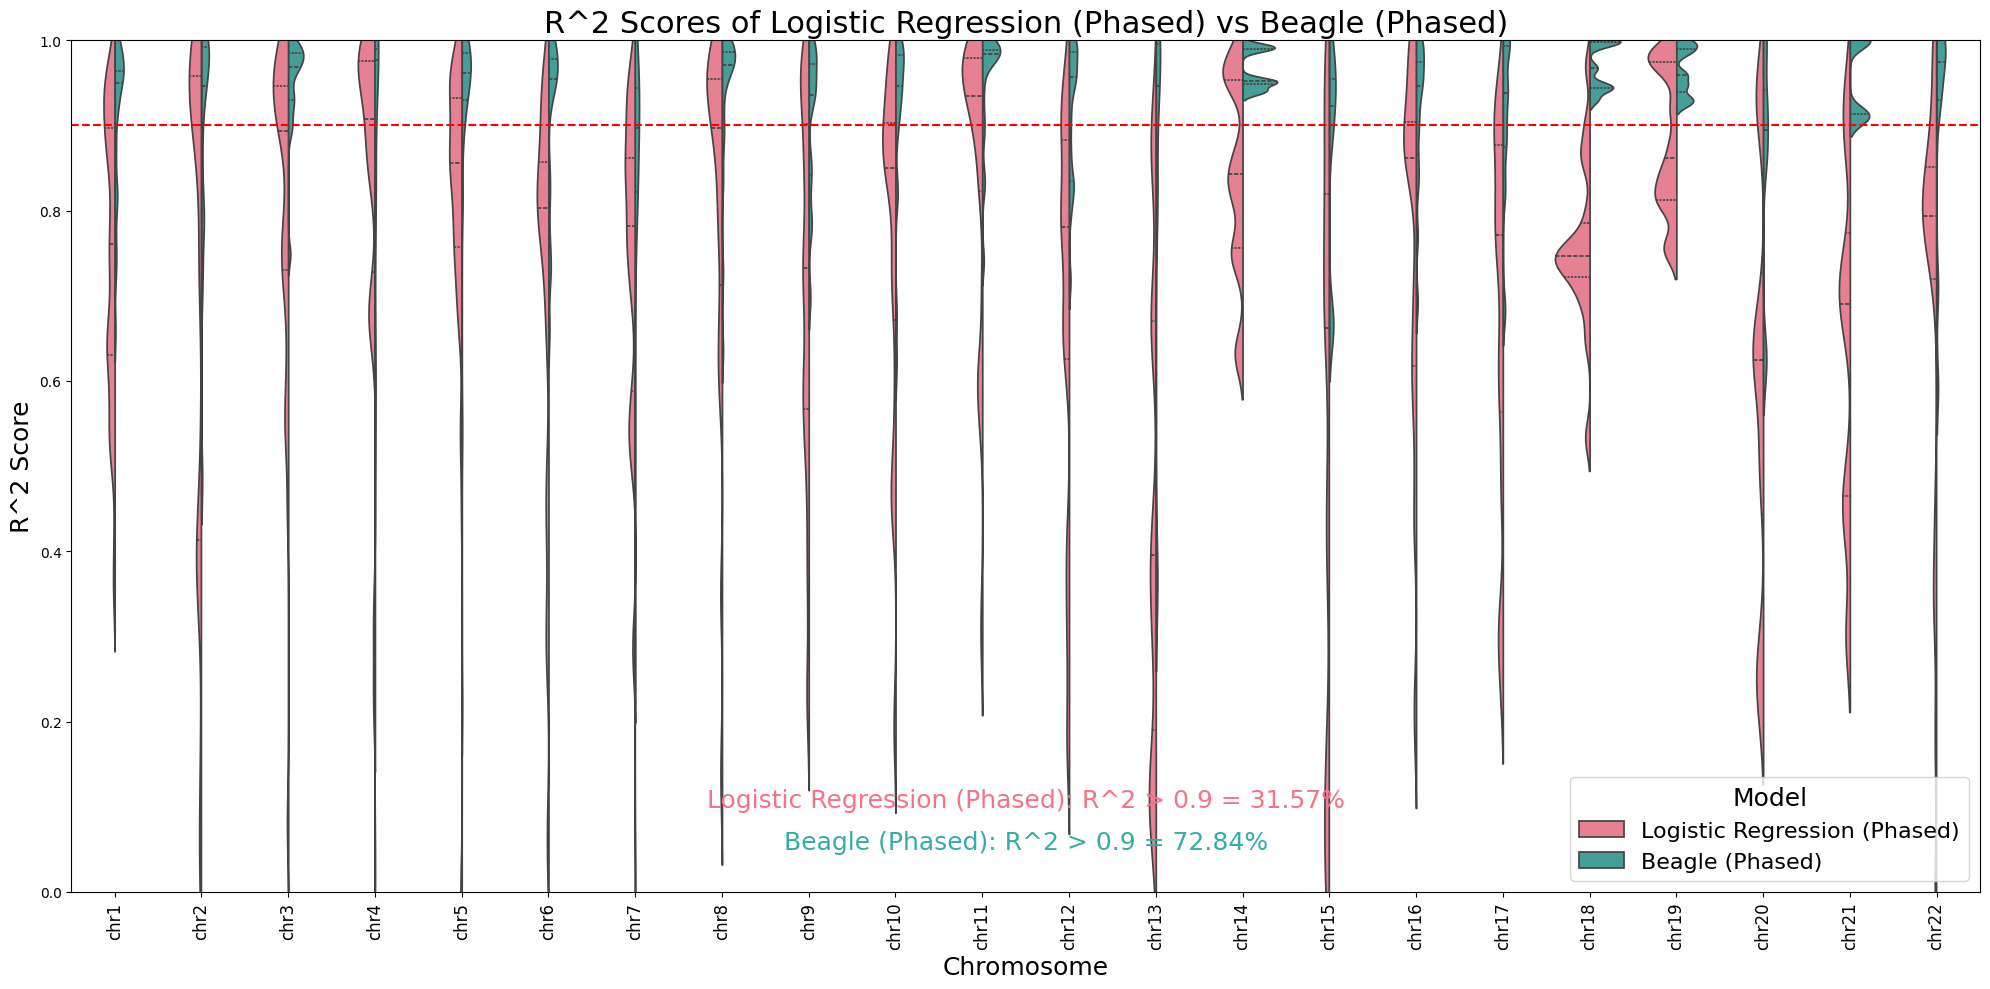

In [15]:
# Define the base directory paths and model names
models = [
    ("../../../Data/model_results/logistic_regression/csv_files", "Logistic Regression (Phased)"),
    ("../../../Data/model_results_unphased_all_PRS/beagle/csv_files", "Beagle (Phased)")
    # Add more tuples for additional models as needed
]

# Create the comparison plot with violin plots
plot_comparison_violin(models)

# Imputation Quality Score Individual

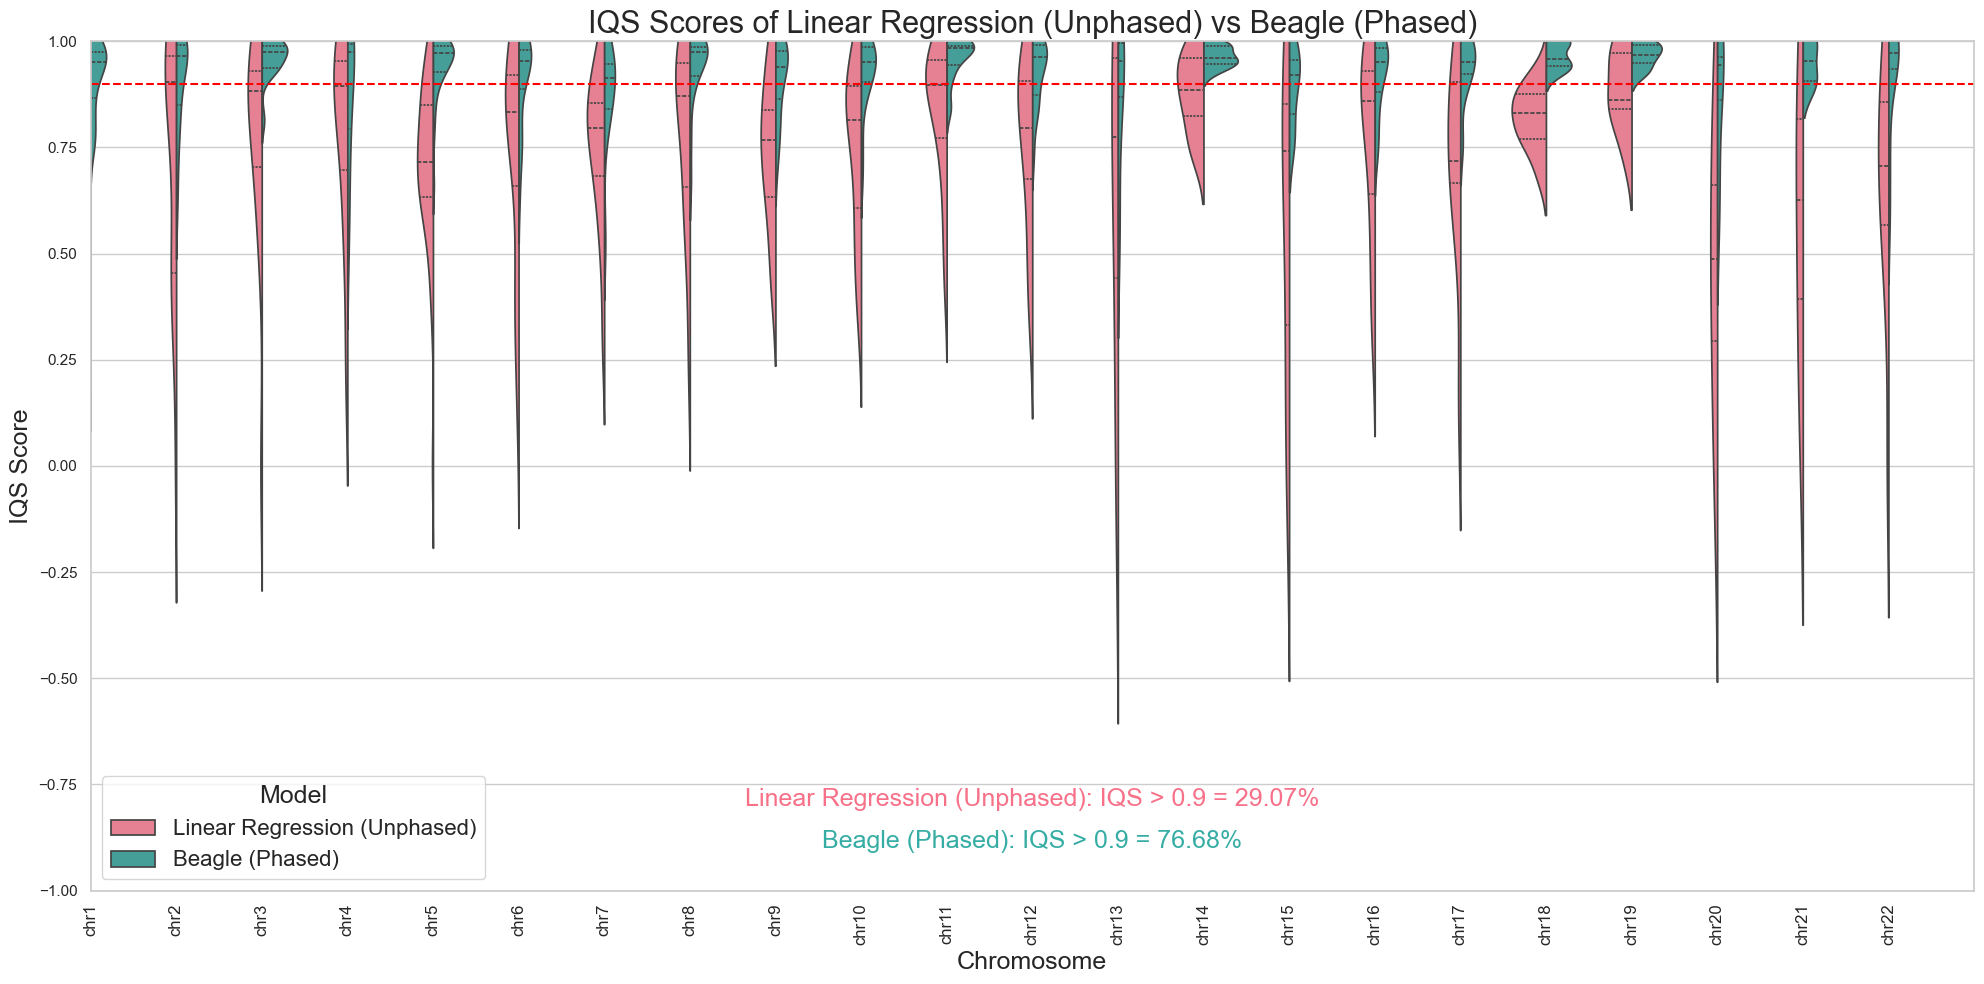

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to read and process CSV file
def read_and_process_csv(base_dir, chr_folder):
    csv_file = os.path.join(base_dir, chr_folder, f'individual_iqs_scores_{chr_folder}.csv')
    df = pd.read_csv(csv_file)
    df[['chromosome', 'position']] = df['SNP'].str.split('_', n=2, expand=True)[[0, 1]]
    df['position'] = pd.to_numeric(df['position'])
    df['chromosome'] = chr_folder  # Add chromosome as a column for easier plotting
    return df

# Define a function to create the violin plot data for a single model
def create_violin_plot_data(base_dir, model_label):
    chr_folders = sorted(
        (folder for folder in os.listdir(base_dir) if folder.startswith('chr')),
        key=lambda x: int(x[3:])
    )
    
    data_frames = []
    for chr_folder in chr_folders:
        df = read_and_process_csv(base_dir, chr_folder)
        df['model'] = model_label  # Add model label as a column
        data_frames.append(df)
    
    return pd.concat(data_frames, ignore_index=True)

# Define a function to plot the comparison with violin plots for multiple models
def plot_comparison_violin(models):
    combined_df = pd.concat(
        [create_violin_plot_data(base_dir, model_name) for base_dir, model_name in models], 
        ignore_index=True
    )

    # Separate outliers from main data
    main_data = combined_df[(combined_df['IQS Score'] >= -1) & (combined_df['IQS Score'] <= 1)]
    outliers = combined_df[(combined_df['IQS Score'] < -1) | (combined_df['IQS Score'] > 1)]

    # Create the violin plot
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    palette = sns.color_palette("husl", len(models))
    sns.violinplot(x='chromosome', y='IQS Score', hue='model', data=main_data, split=True, inner='quart', palette=palette)
    plt.axhline(y=0.9, color='red', linestyle='--', linewidth=1.5)
    plt.title(f'IQS Scores of {models[0][1]} vs {models[1][1]}', fontsize=22)
    plt.xlabel('Chromosome', fontsize=18)
    plt.ylabel('IQS Score', fontsize=18)
    plt.xticks(rotation=90, fontsize=12)
    plt.legend(title='Model', fontsize=16, title_fontsize=18, fancybox=True)

    plt.axis([0, 22, -1, 1])


    # Plot outliers separately with model-specific colors
    model_color_map = {model_name: color for (base_dir, model_name), color in zip(models, palette)}
    
    for _, outlier in outliers.iterrows():
        y_position = -1.25 if outlier['IQS Score'] < -1 else 1.25
        model_color = model_color_map[outlier['model']]
        plt.scatter(outlier['chromosome'], y_position, color=model_color, edgecolor=model_color, s=100, linewidth=2, facecolor='none')
        
        # Adjust label position
        offset = 0.075 if y_position == 1.25 else -0.075
        plt.text(outlier['chromosome'], y_position + offset, f"{outlier['IQS Score']:.2f}", color='black', fontsize=12, ha='center', va='center')

    # Calculate and display the proportion of data points with R² > 0.9 for each model
    for i, (base_dir, model_name) in enumerate(models):
        model_data = combined_df[combined_df['model'] == model_name]
        proportion_above_0_9 = (model_data['IQS Score'] > 0.9).mean()
        plt.text(0.5, 0.1 - 0.05 * i, f'{model_name}: IQS > 0.9 = {proportion_above_0_9:.2%}', transform=plt.gca().transAxes, fontsize=18, color=palette[i], ha='center')

    plt.tight_layout()
    plt.show()

# Define the base directory paths and model names
models = [
    ("../../../Data/model_results_unphased_all_PRS/linear_regression/csv_files", "Linear Regression (Unphased)"),
    ("../../../Data/model_results_unphased_all_PRS/beagle/csv_files", "Beagle (Phased)")
    # Add more tuples for additional models as needed
]

# Create the comparison plot with violin plots
plot_comparison_violin(models)
